In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_excel('/kaggle/input/online-retail-dataset/online_retail_II.xlsx' , sheet_name= 'Year 2009-2010')

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
df['Invoice'].nunique()

28816

**Dropping The null Customer ID's rows**

In [6]:
df= df.dropna(subset=['Customer ID'])

**Remove negative Quantity and UnitPrice**

In [7]:
df=df[(df['Quantity']>0) & (df['Price']>0)]

**Checking For Duplicates**

In [8]:
df.duplicated().sum()

6748

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

0

**Feature Engineering: RFM Analysis**

In [11]:
import datetime as dt

df['TotalPrice'] = df['Quantity'] * df['Price']
snapshot_data= df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm= df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_data - x.max()).days, #Recency
    'Invoice' : 'nunique',                                   #Frequency
    'TotalPrice' : 'sum'                                     #Monetary
})
rfm.columns= ['Recency', 'Frequency', 'Monetary']
rfm=rfm[(rfm['Monetary']>0)]

# Data Visualization

**Distribution Plots**

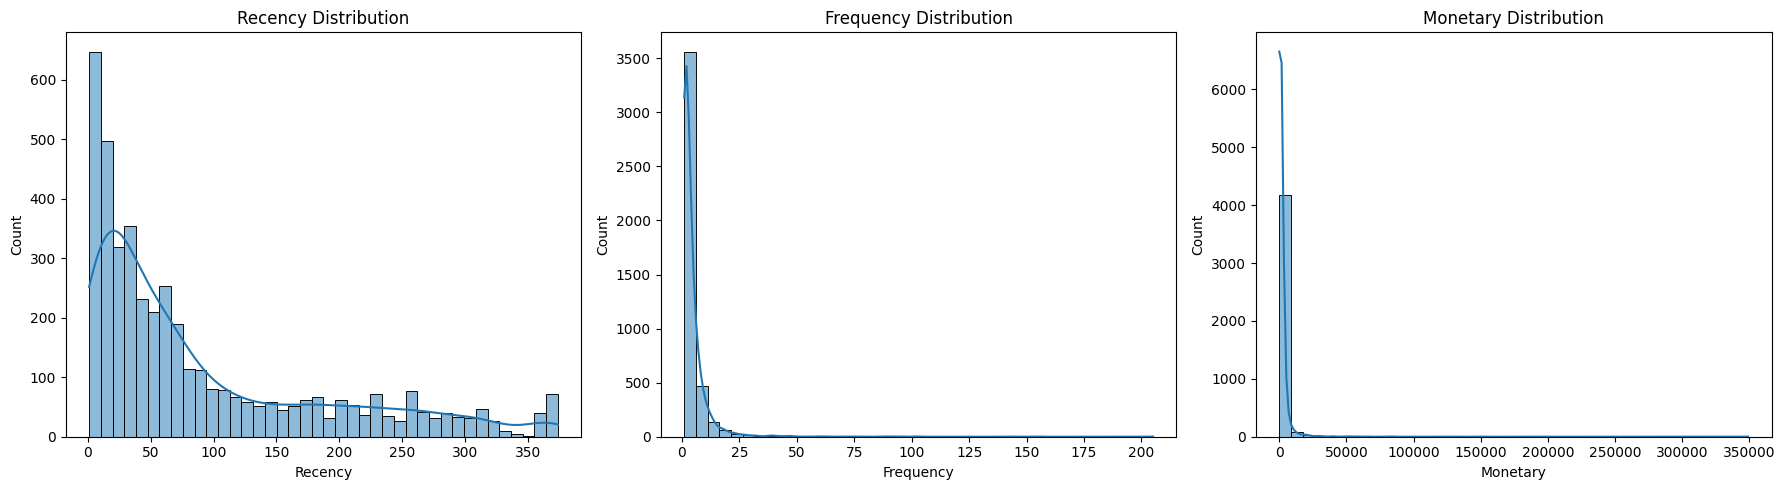

In [12]:
fig, axs= plt.subplots(1,3, figsize=(18,5))
sns.histplot(rfm['Recency'] , bins=40 , ax=axs[0] , kde=True)
axs[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'] , bins=40 , ax=axs[1] , kde= True)
axs[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'] , bins=40 , ax=axs[2] , kde=True)
axs[2].set_title('Monetary Distribution')


plt.tight_layout()
plt.show()

**Saclaing The Data**

In [13]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
rfm_scaled= pd.DataFrame(scaler.fit_transform(rfm), columns=rfm.columns)

# Kmeans

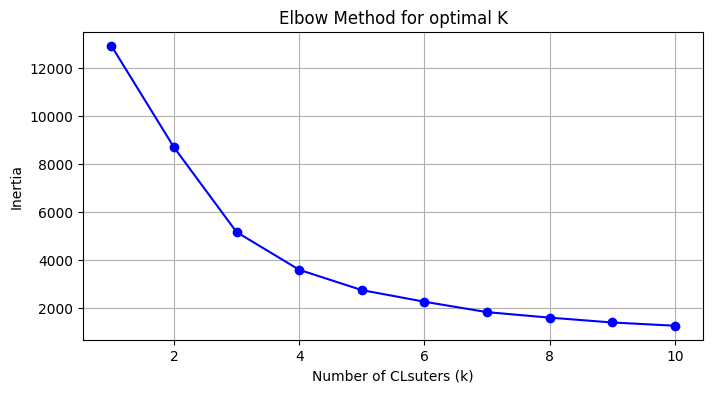

In [14]:
from sklearn.cluster import KMeans

inertia = []
K = range(1,11)

for k in K:
    kmeans = KMeans(n_clusters=k ,init='k-means++' ,random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8,4))
plt.plot(K, inertia , 'bo-')
plt.xlabel("Number of CLsuters (k)")
plt.ylabel('Inertia')
plt.title('Elbow Method for optimal K')
plt.grid(True)
plt.show()

In [15]:
kmeans = KMeans(n_clusters=4 , init='k-means++' , random_state = 42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

**Using 2D PCA for cluster visualization**

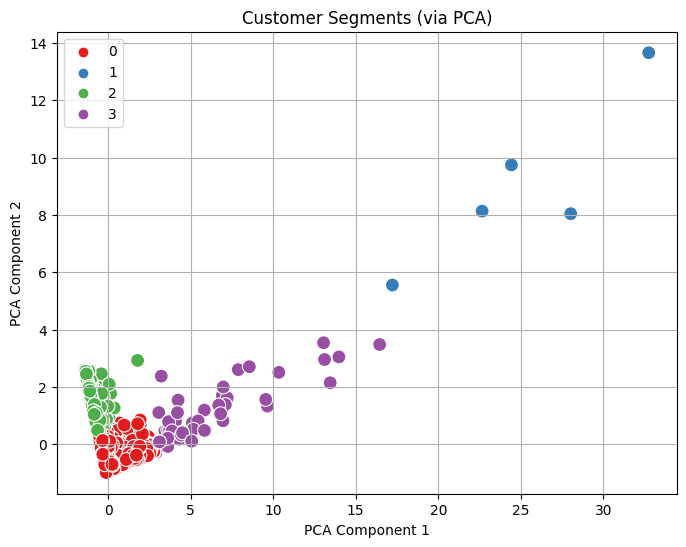

In [16]:
from sklearn.decomposition import PCA

pca = PCA(2)
pca_components = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=rfm['Cluster'], palette='Set1', s=100)
plt.title('Customer Segments (via PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


**Interpretation of Clusters**

In [17]:
cluster_summary = rfm.groupby('Cluster').mean().round(1)
print(cluster_summary)

         Recency  Frequency  Monetary
Cluster                              
0           43.0        4.5    1710.7
1            5.6      113.6  215535.0
2          243.0        1.7     593.5
3           14.9       47.0   28896.4


| Cluster | Recency ↓ | Frequency ↑ | Monetary ↑    | Interpretation                                                                    |
| ------- | --------- | ----------- | ------------- | --------------------------------------------------------------------------------- |
| **0**   | 43.0      | 4.5         | 1,710.7       | 🟡 **Average customers** – moderately recent, not very frequent or high spenders. |
| **1**   | 243.0     | 1.7         | 593.5         | 🔴 **At risk / Churned** – long inactive, low frequency and spend.                |
| **2**   | **5.6**   | **113.6**   | **215,535.0** | 🟢 **Champions / VIPs** – very recent, very frequent, massive spenders.           |
| **3**   | 14.9      | 47.0        | 28,896.4      | 🔵 **Loyal Customers** – active recently, frequent buyers, strong spenders.       |


**Final Labels**

In [18]:
rfm['Label'] = rfm['Cluster'].map({
    0: 'Regulars',
    1: 'Churned',
    2: 'Champions',
    3: 'Loyal Customers'
})
